In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
print('imported')

imported


In [2]:
path = '../../data/'
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']

In [3]:
def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df["doy"]      = df["datetime"].dt.dayofyear
    df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    
    df['time']     = df['datetime'].dt.time
    df['hour']     = df['datetime'].dt.hour
    df["minute"]   = df["datetime"].dt.minute
    df["second"]   = df["datetime"].dt.second
    
    df['datetime_1h']  = df['datetime'].dt.floor('1h')
    df['datetime_5min']  = df['datetime'].dt.floor('5min')
    df['datetime_1min']  = df['datetime'].dt.floor('1min')
    
    df.drop(['click_time'], axis=1, inplace=True)
    return df

def devideDateTime(df):
    tmp = df.click_time.str.split(" ")
    df["date"] = tmp.str[0]
    df["time"] = tmp.str[1]
    
    tmp = df.time.str.split(":")
    df["hour"] = tmp.str[0]
    df["minute"] = tmp.str[1]
    df["date_hour"] = df["date"] + ' ' + df["hour"]
    return df

In [4]:
%%time
train_df = pd.read_csv(path+"train.csv",
                       nrows=5000000,
                       dtype=dtypes,
                       usecols=train_columns)

CPU times: user 1.86 s, sys: 124 ms, total: 1.98 s
Wall time: 1.99 s


In [5]:
%%time
sample_df = pd.read_csv(path+"train_sample.csv",
                        dtype=dtypes,
                        usecols=train_columns)

CPU times: user 61.4 ms, sys: 7.84 ms, total: 69.2 ms
Wall time: 70.3 ms


In [6]:
%time
test_df = pd.read_csv(path+"test.csv",
                      nrows=1000000,
                      dtype=dtypes,
                      usecols=test_columns)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


### 前処理
---
とりあえず時間の分割．  
trainは 2017-11-06 (MON) ~ 2017-11-09 (THU) だが，testは2017-11-10 (FRI)で，中国でもすべて平日．曜日情報は使えないっぽい．  
~~現地時間では 2017-11-07(TUE) 00:00 ~ 2017-11-09(THU) 24:00 ．~~  
trainは 2017-11-06(MON) 22:32:21 〜 だった．

train.head()のデータがおかしい．時間の偏りがないとして $184903890/(3*24*60*60)=713.3$ なので秒間数百clickありそうなものだが，数分に1回しかない．  
→ 2017-11-06 (MON) 16:00:00から突然それっぽいデータ量になるので，16時より前は捨ててもいいっぽい．tailも同じようなのがありそう．

test_dfは 2017-11-10 04:00:00 ~ 2017-11-10 15:00:00．現地時間でも11/10に収まる．

In [7]:
train_df = timeFeatures(train_df)

In [8]:
sample_df = timeFeatures(sample_df)

In [9]:
test_df = timeFeatures(test_df)

In [10]:
print(np.min(train_df.datetime), np.max(train_df.datetime))
print(np.min(sample_df.datetime), np.max(sample_df.datetime))
print(np.min(test_df.datetime), np.max(test_df.datetime))

2017-11-06 14:32:21 2017-11-06 20:27:57
2017-11-06 16:00:00 2017-11-09 15:59:51
2017-11-10 04:00:00 2017-11-10 04:17:35


### ip別クリック回数，ダウンロード回数
---
意外とクリック数の裾が長い．
~~クリック数が多ければ引っかかるってものでもないらしい．~~
train_sampleだとあまり関係が認められなかったが，500万件引っ張ってきたら結構関係ありそう．rateとの相関は弱い．


correlation matrix
           click    attrib      rate
click   1.000000  0.474066 -0.058418
attrib  0.474066  1.000000  0.467554
rate   -0.058418  0.467554  1.000000


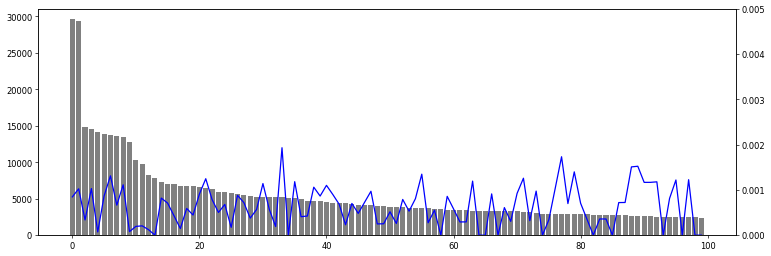

In [11]:
data = train_df
key = 'ip'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

nrows = 100

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.005)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

<BarContainer object of 150 artists>

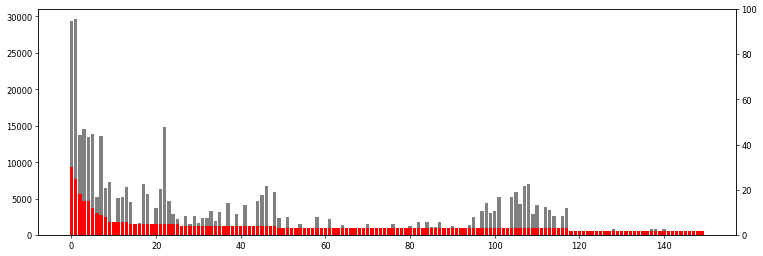

In [12]:
data_grp = data_grp.sort_values(by='attrib', ascending=False)
nrows = 150

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax2 = ax1.twinx()
ax2.set_ylim(0,100)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.bar(np.arange(nrows), data_grp['attrib'][:nrows], color="red")

### os別クリック回数，ダウンロード回数
---
一部のosで突出してダウンロード率が高い．10%超えたりする．

correlation matrix
           click    attrib      rate
click   1.000000  0.743946 -0.036454
attrib  0.743946  1.000000  0.183225
rate   -0.036454  0.183225  1.000000


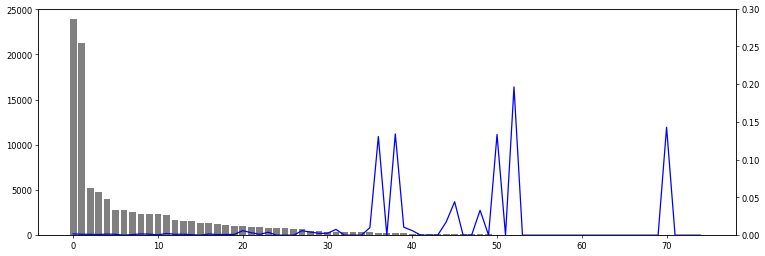

In [13]:
data = sample_df
key = 'os'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

nrows = 75

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.3)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

In [14]:
print(data_grp[data_grp.rate >= 0.01])

      os  click  attrib      rate
0      0    199      26  0.130653
24    24    194      26  0.134021
42    43    190       2  0.010526
129  866    115       2  0.017391
7      7    113       5  0.044248
37    38     91       3  0.032967
21    21     60       8  0.133333
29    29     56      11  0.196429
56    59     14       2  0.142857
58    61      4       4  1.000000


### 時点別クリック回数，ダウンロード回数
---
Talkingdataは中国の会社らしいので，時差は+8h  
時間帯による差．

correlation matrix
           click    attrib      rate
click   1.000000  0.684868  0.136249
attrib  0.684868  1.000000  0.672068
rate    0.136249  0.672068  1.000000


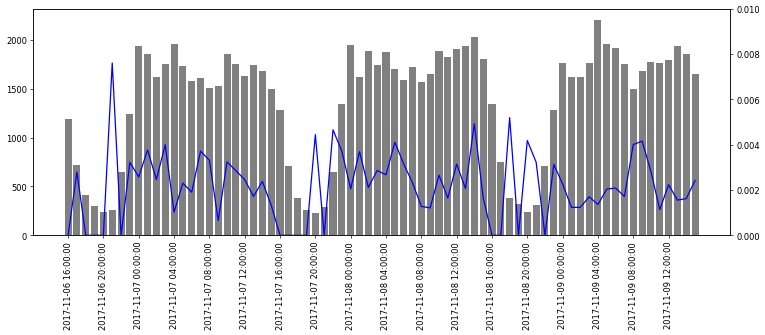

In [15]:
data = sample_df
key = 'datetime_1h'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
# data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

nrows = len(data_grp.index)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax1.set_xticks(np.arange(nrows, step=4))
ax1.set_xticklabels(data_grp[key][np.mod(data_grp.index, 4)==0], rotation=90)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.01)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

### DEVICE別クリック回数，ダウンロード割合
---
> device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

と言うが，適当にググった感じではそこまで独占状態にあるわけではなさそうなので， device = 1 は「不明」か「その他」なんじゃないかという気がする．

Top 10 Most Popular Smartphones in China 2017 (According to Weibo)
https://www.whatsonweibo.com/top-10-popular-smartphone-brands-china-2017-according-weibo/

Huawei led the China Smartphone Market & The Top Four Chinese Brands Captured a Record 67% Share in 2017
https://www.counterpointresearch.com/huawei-led-china-smartphone-market-top-four-chinese-brands-captured-record-67-share-2017/

correlation matrix
           click    attrib      rate
click   1.000000  0.957055 -0.026004
attrib  0.957055  1.000000 -0.024813
rate   -0.026004 -0.024813  1.000000


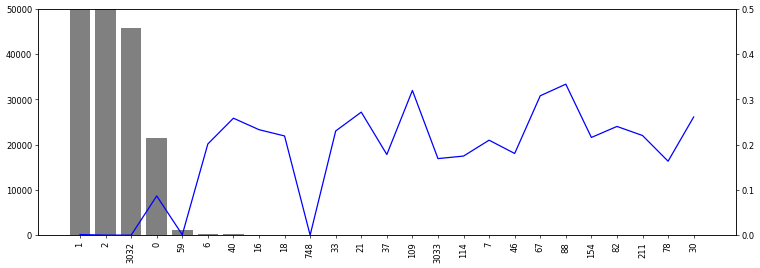

In [16]:
data = train_df
key = 'device'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

# nrows = len(data_grp.index)
nrows = 25

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax1.set_xticks(np.arange(nrows, step=1))
ax1.set_xticklabels(data_grp[key][np.mod(data_grp.index, 1)==0], rotation=90)
ax1.set_ylim(0, 50000)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.5)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

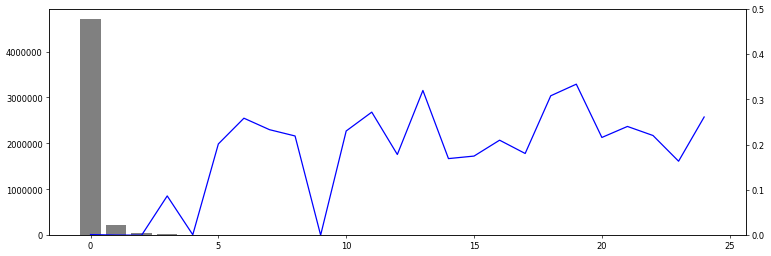

In [17]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.5)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

### App別クリック回数，ダウンロード割合
---
Click数の少ないappがエグい．app = 27 以降の10数個のappはクリック数もそこそこあるがダウンロード率が高い．

correlation matrix
           click    attrib      rate
click   1.000000  0.199772 -0.089371
attrib  0.199772  1.000000  0.130481
rate   -0.089371  0.130481  1.000000


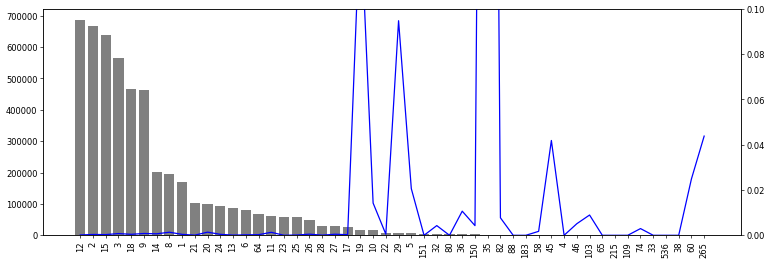

In [18]:
data = train_df
key = 'app'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

# nrows = len(data_grp.index)
nrows = 50

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax1.set_xticks(np.arange(nrows, step=1))
ax1.set_xticklabels(data_grp[key][np.mod(data_grp.index, 1)==0], rotation=90)
# ax1.set_ylim(0, 1000)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.1)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

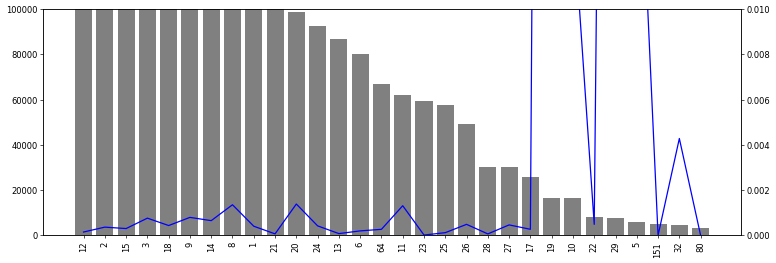

In [19]:
nrows = 30

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax1.set_xticks(np.arange(nrows, step=1))
ax1.set_xticklabels(data_grp[key][np.mod(data_grp.index, 1)==0], rotation=90)
ax1.set_ylim(0, 100000)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.01)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

### Ad channel別クリック回数，ダウンロード割合
---
（Channelが何を指すのかよくわからん）  
一部突出してダウンロード割合の高いchannelがある．ほんのりclick回数とrateに逆相関があるようにも見える（500万件抽出時 corr=-0.124698）

correlation matrix
           click    attrib      rate
click   1.000000  0.023863 -0.124698
attrib  0.023863  1.000000  0.355575
rate   -0.124698  0.355575  1.000000


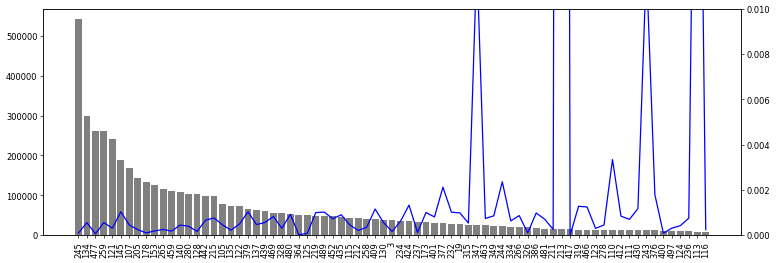

In [20]:
data = train_df
key = 'channel'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

# nrows = len(data_grp.index)
nrows = 75

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax1.set_xticks(np.arange(nrows, step=1))
ax1.set_xticklabels(data_grp[key][np.mod(data_grp.index, 1)==0], rotation=90)
# ax1.set_ylim(0, 1000)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.01)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

# 時間単位別
---
hour別にはデータの偏りがある．現地時間の24時〜7時は少ない
minute別，second別には偏りは見られない（10万件sampleだが…）

correlation matrix
           click    attrib      rate
click   1.000000  0.837135  0.257571
attrib  0.837135  1.000000  0.665993
rate    0.257571  0.665993  1.000000


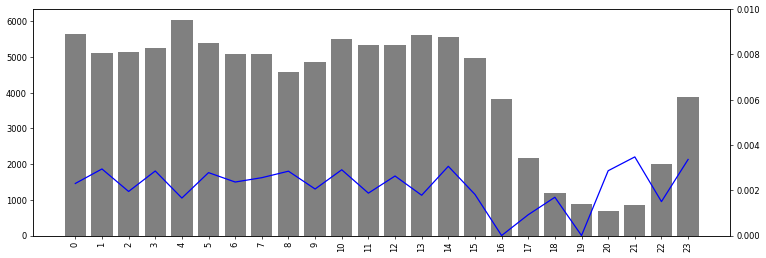

In [22]:
data = sample_df
key = 'hour'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
# data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

nrows = len(data_grp.index)
# nrows = 75

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax1.set_xticks(np.arange(nrows, step=1))
ax1.set_xticklabels(data_grp[key][np.mod(data_grp.index, 1)==0], rotation=90)
# ax1.set_ylim(0, 1000)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.01)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

correlation matrix
           click    attrib      rate
click   1.000000 -0.037368 -0.115918
attrib -0.037368  1.000000  0.996505
rate   -0.115918  0.996505  1.000000


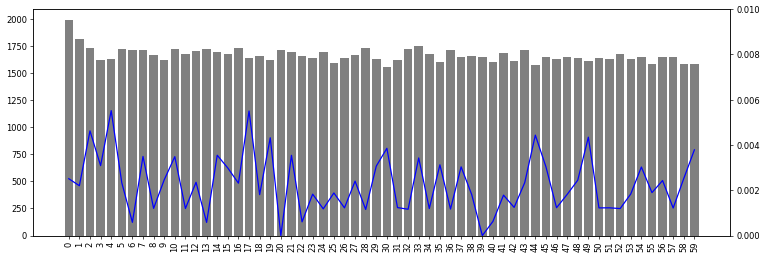

In [23]:
data = sample_df
key = 'minute'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
# data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

nrows = len(data_grp.index)
# nrows = 75

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax1.set_xticks(np.arange(nrows, step=1))
ax1.set_xticklabels(data_grp[key][np.mod(data_grp.index, 1)==0], rotation=90)
# ax1.set_ylim(0, 1000)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.01)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")

correlation matrix
           click    attrib      rate
click   1.000000  0.014656 -0.047872
attrib  0.014656  1.000000  0.997600
rate   -0.047872  0.997600  1.000000


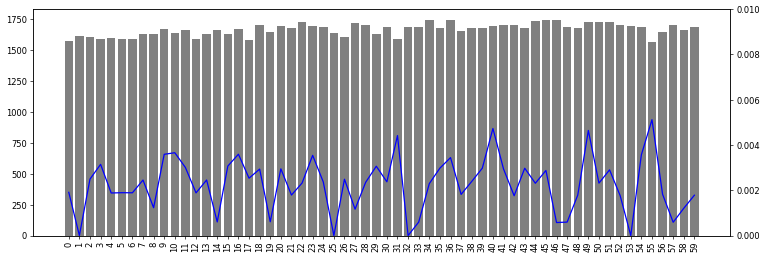

In [24]:
data = sample_df
key = 'second'

data_grp = data[[key, 'is_attributed']].groupby(key, as_index=False)
df_cnt = data_grp.count().rename(columns={'is_attributed':'click'})
df_sum = data_grp.sum().rename(columns={'is_attributed':'attrib'})

data_grp = pd.merge(df_cnt, df_sum, how='left', on=key)
data_grp["rate"] = data_grp.attrib.values / data_grp.click.values
# data_grp = data_grp.sort_values(by='click', ascending=False)

print("correlation matrix")
print(data_grp[["click", "attrib", "rate"]].corr())

nrows = len(data_grp.index)
# nrows = 75

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=60)
ax1.set_xticks(np.arange(nrows, step=1))
ax1.set_xticklabels(data_grp[key][np.mod(data_grp.index, 1)==0], rotation=90)
# ax1.set_ylim(0, 1000)
ax2 = ax1.twinx()
ax2.set_ylim(0, 0.01)
ax1.bar(np.arange(nrows), data_grp['click'][:nrows], color="gray")
ax2.plot(np.arange(nrows), data_grp['rate'][:nrows], color="blue")